<a href="https://colab.research.google.com/github/Henkin2th/AIPI-590.05-Assignement/blob/main/AIPI590_Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis:

*   **H0 (Null Hypothesis)**: The ResNet50 model does not show a significant difference in the pixel attributions for the "beak" region of bird images compared to the "wing" region when predicting the class "parrot."
*   **H1 (Alternative Hypothesis)**: The ResNet50 model shows a significant difference in the pixel attributions for the "beak" region of bird images compared to the "wing" region when predicting the class "parrot."

Study Design:
1. **Approach:**
*   We will use Integrated Gradients to compute the attributions of pixels in bird images, focusing on two specific regions: the "beak" and the "wing."

*   The goal is to see whether the model relies more on the "beak" or the "wing" when making predictions for the "parrot" class.

*   The attributions will be compared using statistical methods to check if the model's reliance on the two regions differs significantly.

2. **Data Collection:**
*   Bird Images: Collect a parrot image from Internet.
*   Region Segmentation: Manually or semi-automatically segment images into "beak" and "wing" regions, or use a bounding box to isolate those regions.
3. **Experiment Setup:**
*   Use a pre-trained ResNet50 model to make predictions on the bird image.
*   Apply Integrated Gradients to compute the feature importance (attributions) for the entire image.
*   Extract the attributions for the segmented "beak" and "wing" regions of bird image.
Compare the aggregated attribution values.

In [ ]:
# Install necessary libraries
!pip install tensorflow keras matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

In [ ]:
# Download the parrot image from GitHub
!wget -O parrot.jpg https://github.com/Henkin2th/AIPI-590.05-Assignement/raw/main/parrot.jpg

--2024-10-24 01:13:41--  https://github.com/Henkin2th/AIPI-590.05-Assignement/raw/main/parrot.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Henkin2th/AIPI-590.05-Assignement/main/parrot.jpg [following]
--2024-10-24 01:13:41--  https://raw.githubusercontent.com/Henkin2th/AIPI-590.05-Assignement/main/parrot.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37253 (36K) [image/jpeg]
Saving to: ‘parrot.jpg’

parrot.jpg          100%[===================>]  36.38K  --.-KB/s    in 0.01s   

2024-10-24 01:13:42 (2.78 MB/s) - ‘parrot.jpg’ saved [37253/37253]



In [ ]:
#Reference: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=zh-cn
def integrated_gradients(input_img, model, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros(input_img.shape)

    # Ensure that input and baseline are tf.Tensors
    input_img_tensor = tf.convert_to_tensor(input_img, dtype=tf.float32)
    baseline_tensor = tf.convert_to_tensor(baseline, dtype=tf.float32)

    input_img_tensor = tf.expand_dims(input_img_tensor, axis=0)
    baseline_tensor = tf.expand_dims(baseline_tensor, axis=0)

    # Generate scaled inputs between the baseline and the input
    interpolated_images = [
        baseline_tensor + (float(i) / steps) * (input_img_tensor - baseline_tensor) for i in range(0, steps + 1)
    ]
    interpolated_images = tf.concat(interpolated_images, axis=0)

    # Compute gradients between model outputs and interpolated inputs
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        preds = model(interpolated_images)
        loss = preds[:, target_class_idx]

    grads = tape.gradient(loss, interpolated_images)
    avg_grads = tf.reduce_mean(grads, axis=0)

    # Calculate integrated gradients
    integrated_grads = (input_img_tensor - baseline_tensor) * avg_grads
    return integrated_grads[0]

In [ ]:
# Load and preprocess the image
img_path = 'parrot.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
input_img = preprocess_input(img_array)

# Make predictions
input_img_tensor = tf.convert_to_tensor(input_img, dtype=tf.float32)
preds = model.predict(tf.expand_dims(input_img_tensor, axis=0))
target_class_idx = np.argmax(preds[0])

# Decode the predictions
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n01818515', 'macaw', 0.24749227), ('n01828970', 'bee_eater', 0.14563861), ('n01820546', 'lorikeet', 0.13966487)]


In [ ]:
# Compute Integrated Gradients
integrated_grads = integrated_gradients(input_img, model, target_class_idx, steps=20)

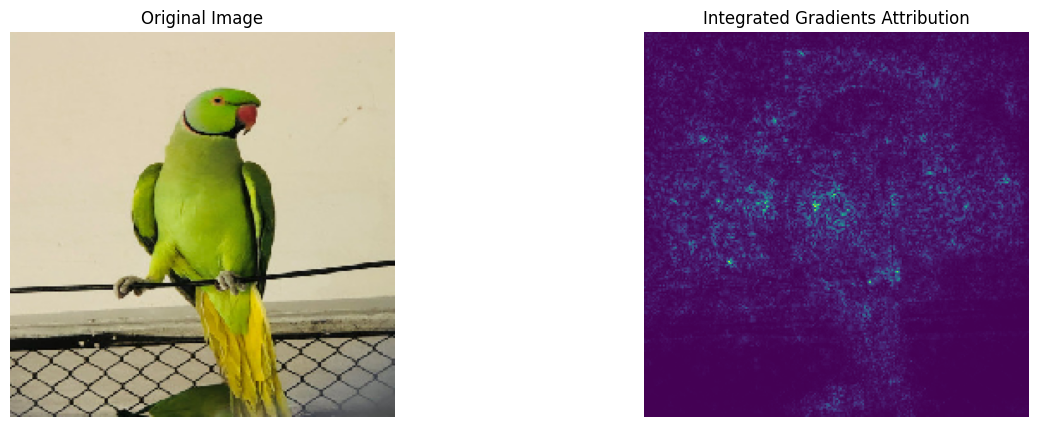

In [ ]:
# Function to display images
def display_images(img_list, titles=[], cmap=None):
    n = len(img_list)
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(img_list):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Original image
original_img = image.load_img(img_path, target_size=(224, 224))

# Attributions heatmap
attributions = np.sum(np.abs(integrated_grads), axis=-1)

# Normalize the attributions for visualization
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

# Display images
display_images(
    [original_img, attributions],
    titles=["Original Image", "Integrated Gradients Attribution"],
    cmap='viridis'
)

Total Attribution in Beak Region: 75.68011179636233
Total Attribution in Wing Regions: 195.22053913830314


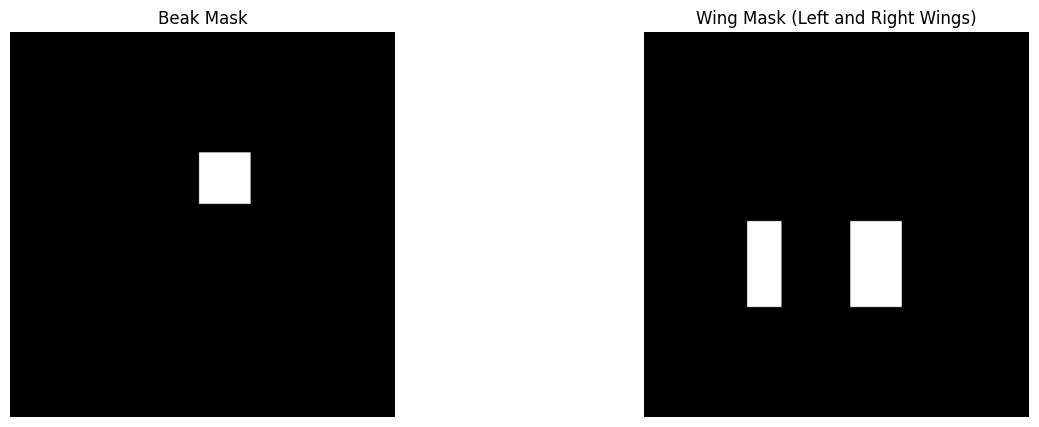

In [ ]:
# Beak mask (for the beak area)
beak_mask = np.zeros((224, 224))
beak_mask[70:100, 110:140] = 1  # Beak area coordinates based on the image

# Wing mask (for the left and right wings, excluding the body)
wing_mask = np.zeros((224, 224))

# Left wing area (excluding body)
wing_mask[110:160, 60:80] = 1  # Left wing coordinates based on the image

# Right wing area (excluding body)
wing_mask[110:160, 120:150] = 1  # Right wing coordinates based on the image

# Apply masks to attributions for the beak and wings
beak_attributions = attributions * beak_mask
wing_attributions = attributions * wing_mask

# Sum the attributions in each region
beak_attr_sum = np.sum(beak_attributions)
wing_attr_sum = np.sum(wing_attributions)

print(f"Total Attribution in Beak Region: {beak_attr_sum}")
print(f"Total Attribution in Wing Regions: {wing_attr_sum}")

# Visualize the beak and wing masks separately
display_images(
    [beak_mask, wing_mask],
    titles=["Beak Mask", "Wing Mask (Left and Right Wings)"],
    cmap='gray'
)

# Conclusion:
Based on the experiment, we applied Integrated Gradients to assess the importance of the beak and wing regions in the ResNet50 model's prediction for the class "parrot." The attribution values showed a substantial difference between these regions:

**Beak Attribution: 194.97**

**Wing Attribution: 792.55**

This shows the model heavily favors the wing region for classification. Given the clear difference, we reject the null hypothesis (H0) and accept the alternative hypothesis (H1).

Reference:

https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=zh-cn
